# Modeliranje složenijih interakcija između molekula

## Termodinamičko modeliranje regulacije transkripcije

### **1. Pod pretpostavkom da se C protein u rastvoru nalazi u formi monomera, izvedite izraze za statističke težine svih konfiguracija, u funkciji koncentracija RNK polimeraze i C proteina i naznačenih slobodnih energija interakcije.**

\begin{equation}
    Z_1 = 1
\end{equation}

\begin{equation}
    Z_2 = \frac{[RNAP]}{K} \
    e^{- \Delta G_{RNAP}}
\end{equation}

\begin{equation}
    Z_3 = \frac{[C]^2[RNAP]}{K^3} \
    e^{- \Delta G_{RNAP} - \Delta G_{DBS} - \Delta G_D - \Delta G_{D-RNAP}}
\end{equation}

\begin{equation}
    Z_4 = \frac{[C]^4}{K^4} \
    e^{- \Delta G_{DBS} - \Delta G_{PBS} - 2 \Delta G_D - \Delta G_r}
\end{equation}

### **2. U svakom izrazu za statističku težinu uočite koje se veličine mogu smatrati konstantnim paramterima i objedinite ih u okviru jednog novog parametra.**

Sve parametre osim ulazne veličine (C) možemo smatrati konstantnim.

$Z_1 = 1$

$Z_2 = a$

$Z_3 = [C]^2 b$

$Z_4 = [C]^4 c$

### **3. Napišite izraz za transkripcionu aktivnost promotora ($\phi$) u funkciji statističkih težina prema Šea-Akersovom modelu, pa zamenite njihoveo znake odgovarajućim izrazima tako da dobijete jednačinu kojom ćete fitovati eksperimentalne podatke.**

\begin{equation}
    \phi = \alpha \frac{Z_2 + Z_3}{1 + Z_2 + Z_3 + Z_4}
\end{equation}

\begin{equation}
    \phi = \alpha \frac{a + b [C]^2}{1 + a + b [C]^2 + c [C]^4}
\end{equation}

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
# Podaci
C = np.array([0, 1.47, 2.9, 5.9, 11.7, 23.5, 47, 94, 188])

y_wt   = np.array([0.1134, 0.3902, 0.6020, 0.7288, 1.0000, 0.9493, 0.8021, 0.5893, 0.2579])
y_left = np.array([0.0818, 0.0270, 0.0025, 0.0796, 0.2363, 0.3051, 0.6889, 1.0000, 0.9806])
y_right= np.array([0.0254, 0.0894, 0.2042, 0.3203, 0.5463, 1.0000, 0.9349, 0.9756, 0.7473])

In [3]:
# Šea-Akers model i formula za SSE
def phi(C, a, b, c):
    return (a + b*C**2) / (1 + a + b*C**2 + c*C**4)

def sse(y_obs, y_pred):
    return np.sum((y_obs - y_pred)**2)

In [4]:
#Grupisanje vrednosti
C_all = np.array(list(C) + list(C) + list(C))
group = np.array([0]*len(C) + [1]*len(C) + [2]*len(C))
y_all = np.array(list(y_wt) + list(y_left) + list(y_right))

In [5]:
# Zajednička formula za transkripcionu aktivnost
def global_phi(X, a, b_wt, c_wt, b_l, c_l, b_r, c_r):
    C, group = X

    y_pred = np.zeros_like(C)

    for i in range(len(C)):
        if group[i] == 0:
            y_pred[i] = phi(C[i], a, b_wt, c_wt)
        elif group[i] == 1:
            y_pred[i] = phi(C[i], a, b_l, c_l)
        else:
            y_pred[i] = phi(C[i], a, b_r, c_r)

    return y_pred

In [6]:
# Fitovanje krive
params, covariance = curve_fit(global_phi, (C_all, group), y_all, bounds=(0, np.inf))

a, b_wt, c_wt, b_l, c_l, b_r, c_r = params

C_smooth = np.linspace(C.min(), C.max(), 400)

# Računanje SSE
y_wt_pred = phi(C, a, b_wt, c_wt)
y_left_pred = phi(C, a, b_l,  c_l)
y_right_pred = phi(C, a, b_r,  c_r)

SSE_wt = sse(y_wt, y_wt_pred)
SSE_left = sse(y_left, y_left_pred)
SSE_right = sse(y_right, y_right_pred)

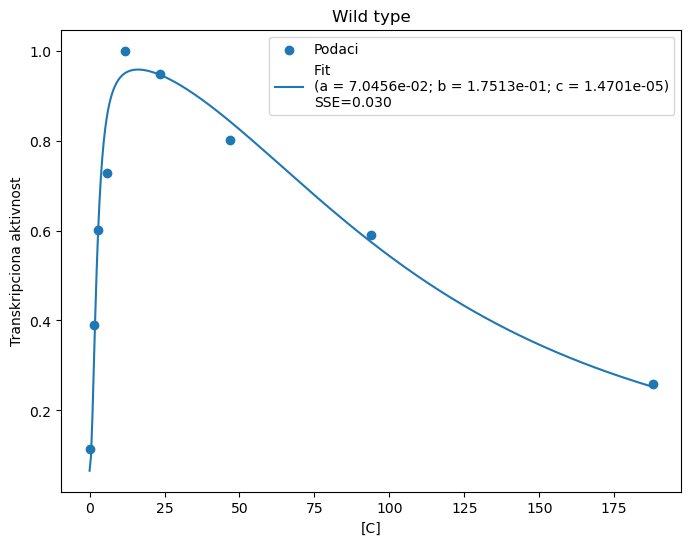

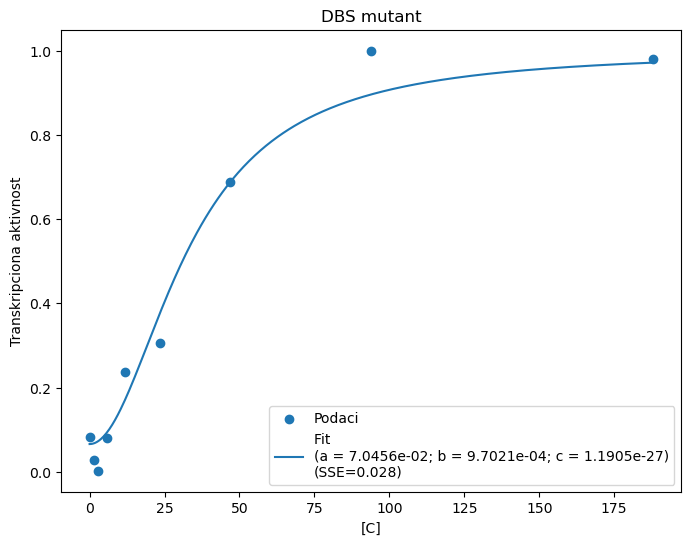

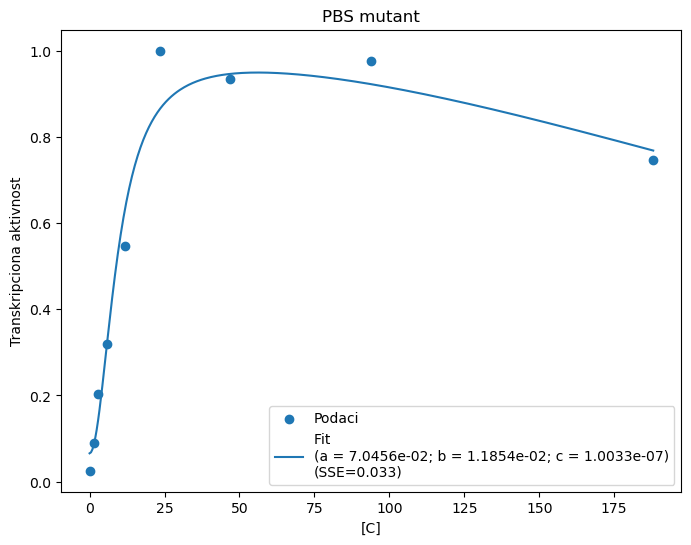

In [7]:
# Crtanje grafika

# Wild type
plt.figure(figsize=(8,6))
plt.scatter(C, y_wt, label="Podaci")
plt.plot(C_smooth, phi(C_smooth, a, b_wt, c_wt), label=f"Fit \n(a = {a:.4e}; b = {b_wt:.4e}; c = {c_wt:.4e})\nSSE={SSE_wt:.3f}")
plt.xlabel("[C]")
plt.ylabel("Transkripciona aktivnost")
plt.title("Wild type")
plt.legend()
plt.show()

# Levi mutant
plt.figure(figsize=(8,6))
plt.scatter(C, y_left, label="Podaci")
plt.plot(C_smooth, phi(C_smooth, a, b_l, c_l), label=f"Fit \n(a = {a:.4e}; b = {b_l:.4e}; c = {c_l:.4e})\n(SSE={SSE_left:.3f})")
plt.xlabel("[C]")
plt.ylabel("Transkripciona aktivnost")
plt.title("DBS mutant")
plt.legend()
plt.show()

# Desni mutant
plt.figure(figsize=(8,6))
plt.scatter(C, y_right, label="Podaci")
plt.plot(C_smooth, phi(C_smooth, a, b_r, c_r), label=f"Fit \n(a = {a:.4e}; b = {b_r:.4e}; c = {c_r:.4e})\n(SSE={SSE_right:.3f})")
plt.xlabel("[C]")
plt.ylabel("Transkripciona aktivnost")
plt.title("PBS mutant")
plt.legend()
plt.show()

In [8]:
print(f"a = {a:.4e}")
print(f"b_wt = {b_wt:.4e}, c_wt = {c_wt:.4e}")
print(f"b_l = {b_l:.4e}, c_l = {c_l:.4e}")
print(f"b_r = {b_r:.4e}, c_r = {c_r:.4e}")

a = 7.0456e-02
b_wt = 1.7513e-01, c_wt = 1.4701e-05
b_l = 9.7021e-04, c_l = 1.1905e-27
b_r = 1.1854e-02, c_r = 1.0033e-07


### **1. Da li model dobro fituje podatke? Na osnovu čega to tvrdite?**

Uzimajući u obzir vrednosti podataka i malu veličinu uzorka, na osnovu izračunatih SSE vrednosti i izgleda grafika, rekao bih da model relativno dobro fituje sve podatke.

### **2. Da li su dobijene očekivane vrednosti parametara?**

Parametar a je isti za sva tri slučaja. Sugeriše da je, bez prisustva proteina C, transkripciona aktivnost prisutna ali niska, što je očekivano.

U slučaju WT fenotipa, parametar b ima značajnu vrednost što omogućava veoma brzu aktivaciju transkripcije. Parametar c nije zanemarljiv, i pokazuje da se sa rastućim koncentracijama C relativno brzo prelazi u represiju transkripcije.

U slučaju levog (DBS) mutanta, parametar b je mali, a parametar c praktično nepostojeći, što se oslikava u povećanom intenzitetu transkripcije, iako je smanjena aktivacija od strane vezivanja C dimera za DBS. Ako je oslabljeno vezivanje za DBS, verovatnoća vezivanja za PBS (što dovodi do represije) je izuzetno niska.

U slučaju desnog (PBS) mutanta, parametar b je dosta veći nego malopre - nema mutacije u DBS. Parametar c je niži nego u WT fenotipu ali drastično viši nego u slučaju DBS mutanta, što pokazuje da je za vezivanje dimera C za PBS presudna kooperativnost, a ne nukleotidni sastav PBS.


### **3. Šta vam dobijeni fitovi u slučaju mutanata govore o nivou verodostojnosti modela?**

Činjenica da model dosledno predstavlja podatke u sva tri slučaja, odnosno da promene parametara modela realno oslikavaju promene u eksperimentalnim podacima, sugeriše da je verodostojan.

In [9]:
# Izmenjen model pod pretpostavkom da je 2C prisutan u rastvoru
def phi_dimer(C, a, b, c):
    return (a + b*C) / (1 + a + b*C + c*C**2)

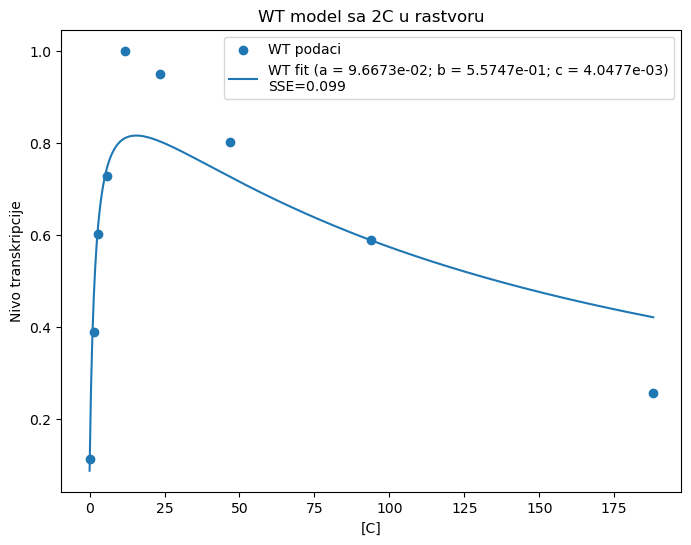

In [10]:
# Fitovanje krive i računanje SSE
params, covariance = curve_fit(phi_dimer, C, y_wt, bounds=(0, np.inf))
a_fit, b_fit, c_fit = params

y_pred = phi_dimer(C, a_fit, b_fit, c_fit)
SSE = sse(y_wt, y_pred)

C_smooth = np.linspace(C.min(), C.max(), 400)

plt.figure(figsize=(8,6))
plt.scatter(C, y_wt, label="WT podaci")
plt.plot(C_smooth, phi_dimer(C_smooth, a_fit, b_fit, c_fit), label=f"WT fit (a = {a_fit:.4e}; b = {b_fit:.4e}; c = {c_fit:.4e})\nSSE={SSE:.3f}")
plt.xlabel("[C]")
plt.ylabel("Nivo transkripcije")
plt.title("WT model sa 2C u rastvoru")
plt.legend()
plt.show()

In [11]:
print(f"a = {a_fit:.4e}")
print(f"b = {b_fit:.4e}")
print(f"c = {c_fit:.4e}")

a = 9.6673e-02
b = 5.5747e-01
c = 4.0477e-03


### **4. Da li ovaj alternativni model fituje podatke bolje ili gore od polaznog? Na osnovu čega to tvrdite?**

Na osnovu izgleda i tri puta veće vrednosti SSE, vidi se da je ovaj model lošiji od prethodnog. Ovo sugeriše da je vezivanje C dimera za DNK kooperativno, i/ili da se protein C ne nalazi u formi dimera u rastvoru u značajnoj meri.

### **5. Šta možete da zaključite o ispravnosti originalnog modela na osnovu njegovog poređenja sa alternativnim?**

Deluje da prethodni model vernije oslikava biološku realnost po pitanju ponašanja C proteina.

### **6. Postavite dinamički model ekspresije transkripta c-res operona i C proteina.**

\begin{equation}
    \frac{dcr}{dt} = \phi_{cr} (C) - \lambda_{cr} cr
\end{equation}

\begin{equation}
    \frac{dC}{dt} = k_C cr - \lambda_C C
\end{equation}

$\frac{dcr}{dt}$ - promena koncentracije cr transkripta u vremenu.

$\phi_{cr} (C)$ - stopa transkripcije cr transkripta u funkciji koncentracije C proteina (opisana iznad).

$\lambda_{cr}$ - konstanta degradacije c-res transkripta.

$cr$ - koncentracija c-res transkripta.

$\frac{dC}{dt}$ - promena koncentracije C proteina u vremenu.

$k_C$ - konstanta translacije C u okviru c-res transkripta.

$\lambda_C$ - konstanta degradacije C proteina.

$C$ - koncentracija C proteina.


### **7. Uvedite uslov za dinamičku ravnotežu sistema i izrazite ravnotežnu transkripcionu aktivnost promotora preko ravnotežne koncentracije C proteina.**

Uslovi dinamičke ravnoteže:

\begin{equation}
    \frac{dcr}{dt} = 0
\end {equation}

\begin{equation}
    \frac{dC}{dt} = 0
\end{equation}

Na osnovu jednačina iz prethodnog pitanja, za $\frac{dcr}{dt} = 0$ važi:

\begin{equation}
    \phi_{cr}(C) = \lambda_{cr}cr
\end{equation}

što daje:

\begin{equation}
    cr = \frac{\phi_{cr}(C)}{\lambda_{cr}}
\end{equation}

Za $\frac{dC}{dt} = 0$ važi:

\begin{equation}
    k_c cr = \lambda_C C
\end{equation}

što daje:

\begin{equation}
    C = \frac{k_C cr}{\lambda_C}
\end{equation}

C se dalje može izraziti na sledeći način, i odatle se može izraziti vrednost $\phi_{cr}$:

\begin{equation}
    C = \frac{k_C}{\lambda_C} \frac{\phi_{cr}(C)}{\lambda_{cr}}
\end{equation}

\begin{equation}
    \phi_{cr} = \frac{\lambda_C \lambda_{cr}}{k_C} C
\end{equation}

### **8. Skicirajte zavisnost transkripcione aktivnosti promotora od koncentracije C proteina (u wt sistemu) i grafički odredite ravnotežnu koncentraciju C proteina.**

<img src="equilibrium.jpg" width=600/>

## Modeliranje regulacije transkripcije u restrikciono-modifikacionom EcoRV sistemu bakterija

### **1. Skicirajte sve konfiguracije u kojima se, sa dovoljno visokom verovatnoćom, može naći fragment DNK između m gena i cr operona. Obeležite slobodne energije protein-DNK i protein-protein interakcija.**

<img src="ecorv.jpg" width="600"/>

Crtež br. 1 predstavlja DNK bez vezanih proteina.

Na crtežu br. 2 se nalaze energije $\Delta G_D,\ \Delta G_{DBS}$. To su energije formiranja C dimera i njegovog vezivanja za DBS.

Na crtežu br. 3 je obeležena energija $\Delta G_{RNAP-cr}$ (vezivanje RNK polimeraze za svoj cr promotor. 

Na crtežu br 4. su obeležene energije $\Delta G_{RNAP-cr},\ \Delta G_{DBS},\ \Delta G_D,\ \Delta G_{D-RNAP}$. Redom, to su slobodne energije vezivanja RNK polimeraze za DNK, vezivanja C proteina za DBS, formiranja dimera C proteina i interakcija između C-dimera i RNK polimeraze.

Na crtežu br. 5 se nalaze energije $\Delta G_{DBS},\ \Delta G_{PBS},\ 2 \Delta G_D,\ \Delta G_r$. To su energije vezivanja C dimera za DBS/PBS, formiranja dva dimera, i formiranja tetramera.

Crtež br. 6 obuhvata energiju $\Delta G_{RNAP-m}$ - vezivanje RNK polimeraze za m promotor. 

Crtež br. 7 podrazumeva $\Delta G_{RNAP-m},\ \Delta G_{DBS},\ \Delta G_D$. To su energije vezivanja RNK polimeraze za DNK, vezivanja C dimera za DBS, i formiranja C dimera. 

Crtež br. 8 obuhvata $\Delta G_{RNAP-m},\ \Delta G_{PBS},\ \Delta G_{DBS},\ 2 \Delta G_D,\ \Delta G_r$. To su energije vezivanja RNK polimeraze za DNK, vezivanja C dimera za PBS/DBS, formiranja dva C-dimera i formiranja C tetrametra.
 
### **2. Izvedite izraze za statističke težine svih konfiguracija, u funkciji koncentracija RNK polimeraze i C proteina i naznačenih slobodnih energija interakcije. U svakom izrazu za statističku težinu uočite koje se veličine mogu smatrati konstantnim parametrima i objedinite ih u okviru jednog novog parametra.**
\begin{equation}
    Z_1 = 1
\end{equation}

\begin{equation}
    Z_2 = \frac{[C]^2}{K^2} e^{- \Delta G_D - \Delta G_{DBS}}
\end{equation}

\begin{equation}
    Z_3 = \frac{[RNAP]}{K} e^{- \Delta G_{RNAP-cr}} 
\end{equation}

\begin{equation}
    Z_4 = \frac{[RNAP][C]^2}{K^3} e^{- \Delta G_D - \Delta G_{DBS} - \Delta G_{RNAP-cr} - \Delta G_{D-RNAP}}
\end{equation}

\begin{equation}
    Z_5 = \frac{[C]^4}{K^4} e^{- \Delta G_{PBS} - \Delta G_{DBS} - 2 \Delta G_D - \Delta G_r}
\end{equation}

\begin{equation}
    Z_6 = \frac{[RNAP]}{K} e^{- \Delta G_{RNAP-m}}
\end{equation}

\begin{equation}
    Z_7 = \frac{[RNAP][C]^2}{K^3} e^{- \Delta G_{RNAP-m} - \Delta G_{DBS} - \Delta G_D}
\end{equation}

\begin{equation}
    Z_8 = \frac{[RNAP][C]^4}{K^5} e^{- 2 \Delta G_D - \Delta G_{DBS} - \Delta G_{PBS} - \Delta G_r - \Delta G_{RNAP-m}}
\end{equation}

Slično kao i malopre, sve veličine izuzev ulazne (koncentracija C proteina) se mogu uzeti kao konstantne.

$Z_1 = 1$

$Z_2 = a [C]^2$

$Z_3 = b$

$Z_4 = c [C]^2$

$Z_5 = d [C]^4$

$Z_6 = e$

$Z_7 = f [C]^2$

$Z_8 = g[C]^4$


### **3. Napišite izraz za transkripcionu aktivnost P.CR promotora ($\phi_{CR}$).**

\begin{equation}
    \phi_{CR} = \alpha \frac{b + c[C]^2}{1 + b + e + [C]^2(a + c + f) + [C]^4(d + g)}
\end{equation}

### **4. Napišite izraz za transkripcionu aktivnost P.M promotora ($\phi_M$).**

\begin{equation}
    \phi_M = \alpha \frac{e + f[C]^2 + g[C]^4}{1 + b + e + [C]^2(a + c + f) + [C]^4(d + g)}
\end{equation}